In [1]:
import pandas as pd

df = df = pd.read_csv("data/training_data_ht2025.csv")
print('data shape: ', df.shape)
# print(df.info())

data shape:  (1600, 16)


In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif

def preprocess(df, n_features=5):
    # 1. Convert the target to numeric: 1 = increase needed, 0 = low demand
    df['increase_stock_numeric'] = (df['increase_stock'] != 'low_bike_demand').astype(int)

    # 2. Define target
    y = df['increase_stock_numeric']

    # 3. Define features (drop original and numeric target columns)
    X = df.drop(columns=['increase_stock', 'increase_stock_numeric'])

    # 4. Encode categorical features (one-hot)
    X_enc = pd.get_dummies(X, drop_first=True)

    # 5. chi2 requires non-negative features -> scale to [0,1]
    mm = MinMaxScaler()
    X_for_chi2 = mm.fit_transform(X_enc)

    # 6. Select top-k features with chi2
    selector = SelectKBest(score_func=chi2, k=n_features)
    # selector = SelectKBest(score_func=f_classif, k=n_features) # alternative using ANOVA F-value
    X_selected = selector.fit_transform(X_for_chi2, y)

    # 7. Get selected column names
    selected_columns = X_enc.columns[selector.get_support()].tolist()
    print(f"Selected top-{n_features} features:", selected_columns)

    # 8. Optionally standardize selected features for modelling
    std = StandardScaler()
    X_final = std.fit_transform(pd.DataFrame(X_selected, columns=selected_columns))

    # 9. Train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_final, y, test_size=0.2, random_state=42
    )

    return X_train, X_val, y_train, y_val, selected_columns

X_train, X_test, y_train, y_test, selected_features = preprocess(df, n_features=7)

Selected top-7 features: ['hour_of_day', 'day_of_week', 'weekday', 'summertime', 'temp', 'dew', 'humidity']


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# implementing kNN and find the best k value (in terms of accuracy)
# k : number of neighbors
best_k = 1
best_accuracy = 0
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_predict)
    print(f'k={k}, accuracy={accuracy}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print('-----------------------------------')
print(f'Best k: {best_k} with accuracy: {best_accuracy}')

k=1, accuracy=0.84375
k=2, accuracy=0.859375
k=3, accuracy=0.8625
k=4, accuracy=0.878125
k=5, accuracy=0.88125
k=6, accuracy=0.88125
k=7, accuracy=0.86875
k=8, accuracy=0.88125
k=9, accuracy=0.86875
k=10, accuracy=0.884375
k=11, accuracy=0.875
k=12, accuracy=0.875
k=13, accuracy=0.865625
k=14, accuracy=0.865625
k=15, accuracy=0.865625
k=16, accuracy=0.8625
k=17, accuracy=0.86875
k=18, accuracy=0.86875
k=19, accuracy=0.8625
k=20, accuracy=0.85625
-----------------------------------
Best k: 10 with accuracy: 0.884375


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       270
           1       0.54      0.50      0.52        50

    accuracy                           0.86       320
   macro avg       0.73      0.71      0.72       320
weighted avg       0.85      0.86      0.85       320



<Figure size 600x400 with 0 Axes>

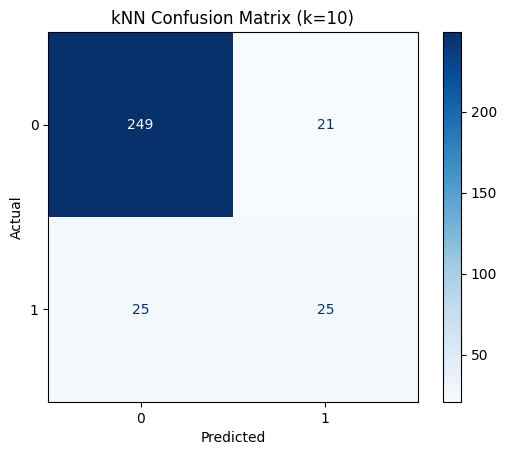

In [4]:
# Model evaluation  
import matplotlib.pyplot as plt

def write_report_and_plot_cm(y_test, y_predict, title='Confusion Matrix'):
    classification_report = metrics.classification_report(y_test, y_predict)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)  
    print("Classification Report:\n", classification_report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix).plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

write_report_and_plot_cm(y_test, y_predict, title=f'kNN Confusion Matrix (k={best_k})')

In [5]:
from sklearn.model_selection import GridSearchCV

# Let's perform hyperparameter tuning using GridSearchCV
params_to_optimized = {'n_neighbors': list(range(1, 21)),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_search_optimized = GridSearchCV(KNeighborsClassifier(), params_to_optimized, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
knn_search_optimized.fit(X_train, y_train)
print('Best score: ', knn_search_optimized.best_score_)
print('Best params: ', knn_search_optimized.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score:  0.88984375
Best params:  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}


In [6]:
# Let's implement kNN with best params

knn_optimized = KNeighborsClassifier(n_neighbors=knn_search_optimized.best_params_['n_neighbors'],
                                     weights=knn_search_optimized.best_params_['weights'],
                                     metric=knn_search_optimized.best_params_['metric'])
knn_optimized.fit(X_train, y_train)
y_predict = knn_optimized.predict(X_test)
accuracy_optimized = metrics.accuracy_score(y_test, y_predict)
print(f'Optimized kNN accuracy: {accuracy_optimized}')


Optimized kNN accuracy: 0.878125


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       270
           1       0.62      0.56      0.59        50

    accuracy                           0.88       320
   macro avg       0.77      0.75      0.76       320
weighted avg       0.87      0.88      0.88       320



<Figure size 600x400 with 0 Axes>

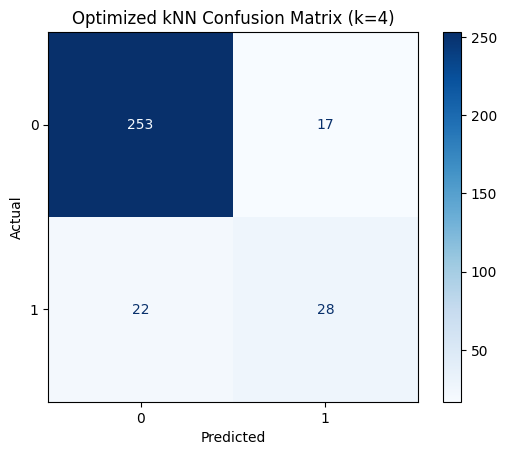

In [7]:
# Model evaluation  
write_report_and_plot_cm(y_test, y_predict, title=f'Optimized kNN Confusion Matrix (k={knn_search_optimized.best_params_["n_neighbors"]})') 

In [8]:
# conclusion
print('-----------------------------------')
print('conclusion:')
print(f'✅ Initial Accuracy : best k: {best_k} with accuracy: {best_accuracy}')
print(f'✅ Tuning kNN accuracy: best k: {knn_search_optimized.best_params_["n_neighbors"]} with accuracy: {accuracy_optimized}')
print(f'⚠️ Accuracy improvement: {accuracy_optimized - best_accuracy}')

-----------------------------------
conclusion:
✅ Initial Accuracy : best k: 10 with accuracy: 0.884375
✅ Tuning kNN accuracy: best k: 4 with accuracy: 0.878125
⚠️ Accuracy improvement: -0.006249999999999978
